In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
test_ID = test.Id
y = train.SalePrice
qualitative = list(train.columns[train.dtypes == "object"])
quantitative = list(test.select_dtypes(include=['float64',"int64"]).columns)
quantitative.remove("Id")




In [84]:
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)
old_cols = [x for x in test.columns if x not in cols]

In [85]:
key = pd.DataFrame(columns=["index"], index=pd.MultiIndex.from_tuples([], names=['variable','value']))

for x in cols:
    kf = train.groupby(x)["SalePrice"].mean().to_frame().sort_values("SalePrice")
    kf = kf.reset_index().reset_index().drop(columns=["SalePrice"])
    kf["variable"] = x
    kf.index = kf.index + 1
    key = pd.concat([key, kf.rename(columns={x:"value"}).set_index(["variable","value"])])



In [86]:
train = train.drop("SalePrice", axis=1)
features = pd.concat([train, test])

reshape_df = pd.melt(features, id_vars="Id", value_vars=cols).merge(key, on=["variable","value"])
qualDf= reshape_df.pivot(index='Id', columns='variable')["index"]
#qualDf.columns = [str(x)+"_E" for x in qualDf.columns]


features = qualDf.merge(features[old_cols], on=["Id"])

In [87]:
#features = features.drop(features[features[cols].isnull().any(axis=1)].index)
features[cols] = features[cols].fillna(0)
features[cols] = features[cols].astype('int')

In [88]:
features = features.drop(columns=["Id"])



In [89]:
from scipy.stats import norm, skew
#https://www.youtube.com/watch?v=smJBsZ4YQZw
numeric_feats = features.dtypes[features.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = features[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolQC,20.723994
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.145323
EnclosedPorch,4.003891


In [90]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    features[feat] = boxcox1p(features[feat], lam)

There are 58 skewed numerical features to Box Cox transform


In [91]:
features[quantitative] = features[quantitative].fillna(0)

In [92]:
features = pd.get_dummies(features)

In [93]:
train = features[:len(y)]
test = features[len(y):]

In [12]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [156]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, np.log1p(y), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [157]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1304 (0.0140)



In [158]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1283 (0.0157)



In [159]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1282 (0.0157)



In [160]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1256 (0.0126)



In [161]:
y_train = np.log1p(y)
LassoMd = lasso.fit(train.values,y_train)
ENetMd = ENet.fit(train.values,y_train)
KRRMd = KRR.fit(train.values,y_train)
GBoostMd = GBoost.fit(train.values,y_train)

In [166]:
finalMd = (np.expm1(LassoMd.predict(test.values)) + np.expm1(ENetMd.predict(test.values)) + np.expm1(KRRMd.predict(test.values)) + np.expm1(GBoostMd.predict(test.values)) ) / 4
finalMd = np.expm1(LassoMd.predict(test.values))



In [167]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = finalMd
sub.to_csv('../output/lasso_submission.csv',index=False)

In [13]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import explained_variance_score, median_absolute_error, r2_score, mean_squared_error #To evaluate our model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone # Clone estimator
from sklearn.metrics import mean_squared_error as MSE


In [95]:
y_train = np.log1p(y)
#lasso alpha gives a standard for how many of the features should have linear coefficients of zero - higher alpha = higher standard

In [98]:
make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))])

In [103]:
from sklearn.linear_model import LinearRegression
seed = 5
n_folds =5
scoring='r2'
model = make_pipeline(RobustScaler(), LinearRegression())
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
cross_val_score(model, train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=1)    

array([0.92504616, 0.87941875, 0.81265179, 0.91243321, 0.76574752,
       0.81113888, 0.94837566, 0.85999633, 0.89044871, 0.88516802])

In [25]:
scaler = StandardScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
model = KNeighborsRegressor()
cross_val_score(model, scaled_train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=1) 


array([0.66227508, 0.72466398, 0.7551283 , 0.74964988, 0.7780703 ,
       0.73586042, 0.76405335])

In [ ]:
#create a pipeline by writing it out or using make_pipeline then you can test how well the model does using cross validation.
#however in order to use it you have to do model.fit()

In [78]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
X, y = make_classification(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data
pipe.score(X_test, y_test)

0.96

In [71]:
#creates a list of models
pipelines = []
seed = 5

pipelines.append(
                ("Scaled_Ridge", 
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Ridge", Ridge(random_state=seed, alpha= 0.1, tol=0.1, solver='auto' ))]
                 )))

pipelines.append(
                ("Scaled_Lasso", 
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Lasso", Lasso(random_state=seed, alpha=.0005, tol=0.1))]
                 )))

pipelines.append(
                ("Scaled_Elastic", 
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Lasso", ElasticNet(random_state=seed, alpha=.0005, tol=0.1))]
                 )))

pipelines.append(
                ("Scaled_RF_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("RF", RandomForestRegressor(random_state=seed))]
                 )))

pipelines.append(
                ("Scaled_ET_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ET", ExtraTreesRegressor(random_state=seed))]
                 )))

pipelines.append(
                ("Scaled_BR_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BaggingRegressor(random_state=seed))]
                 ))) 

pipelines.append(
                ("Scaled_Hub-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Hub-Reg", HuberRegressor())]
                 ))) 

pipelines.append(
                ("Scaled_BayRidge",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BayesianRidge())]
                 ))) 

pipelines.append(
                ("Scaled_XGB_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("XGBR", XGBRegressor(seed=seed, n_estimators=300))]
                 ))) 

pipelines.append(
                ("Scaled_DT_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("DT_reg", DecisionTreeRegressor())]
                 ))) 

"""pipelines.append(
                ("Scaled_SVR",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("SVR",  SVR(kernel='linear', C=1e3, degree=2))]
                 )))"""

pipelines.append(
                ("Scaled_KNN_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("KNN_reg", KNeighborsRegressor())]
                 )))
pipelines.append(
                ("Scaled_ADA-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ADA-reg", AdaBoostRegressor())
                 ]))) 

pipelines.append(
                ("Scaled_Gboost-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("GBoost-Reg", GradientBoostingRegressor())]
                 )))

pipelines.append(
                ("Scaled_RFR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", RandomForestRegressor())]
                 )))

pipelines.append(
                ("Scaled_XGBR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", XGBRegressor())]
                 )))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'r2'
n_folds = 7

results, names  = [], [] 

for name, model  in pipelines:
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    


Scaled_Ridge: 0.864244 (+/- 0.047072)
Scaled_Lasso: 0.835288 (+/- 0.056140)
Scaled_Elastic: 0.829692 (+/- 0.054350)
Scaled_RF_reg: 0.867030 (+/- 0.012854)
Scaled_ET_reg: 0.872291 (+/- 0.013963)
Scaled_BR_reg: 0.855634 (+/- 0.017623)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs fa

Scaled_Hub-Reg: 0.869285 (+/- 0.046844)
Scaled_BayRidge: 0.876201 (+/- 0.045216)
Scaled_XGB_reg: 0.872813 (+/- 0.013412)
Scaled_DT_reg: 0.715333 (+/- 0.039137)
Scaled_KNN_reg: 0.736898 (+/- 0.035736)
Scaled_ADA-Reg: 0.803815 (+/- 0.037058)
Scaled_Gboost-Reg: 0.892661 (+/- 0.013538)
Scaled_RFR_PCA: 0.811648 (+/- 0.021326)
Scaled_XGBR_PCA: 0.801348 (+/- 0.021870)


[Text(0, 0, 'Scaled_Ridge'),
 Text(0, 0, 'Scaled_Lasso'),
 Text(0, 0, 'Scaled_Elastic'),
 Text(0, 0, 'Scaled_RF_reg'),
 Text(0, 0, 'Scaled_ET_reg'),
 Text(0, 0, 'Scaled_BR_reg'),
 Text(0, 0, 'Scaled_Hub-Reg'),
 Text(0, 0, 'Scaled_BayRidge'),
 Text(0, 0, 'Scaled_XGB_reg'),
 Text(0, 0, 'Scaled_DT_reg'),
 Text(0, 0, 'Scaled_KNN_reg'),
 Text(0, 0, 'Scaled_ADA-Reg'),
 Text(0, 0, 'Scaled_Gboost-Reg'),
 Text(0, 0, 'Scaled_RFR_PCA'),
 Text(0, 0, 'Scaled_XGBR_PCA')]

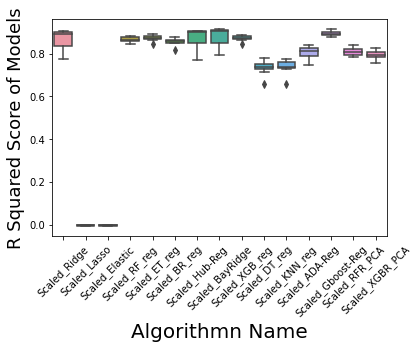

In [67]:

n = []
for x in range(len(names)): n += [[names[x],results[x][y]] for y in range(7)]
model_df = pd.DataFrame(n,columns=["name","result"])
ax = sns.boxplot(data=model_df, x="name", y='result')
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn Name", fontsize=20)
ax.set_ylabel("R Squared Score of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

In [39]:
from tpot import TPOTRegressor
## It's a implementation of some customized models to do in future
tpot_config = {
    'sklearn.ensemble.LassoRegressor': {
        ''
    },
    'xgboost.XGBRegressor': {
        'alpha': [1e-3, 1e-2, 1e-1, 1., 10., 100.],
        'fit_prior': [True, False]
    },
    'sklearn.naive_bayes.MultinomialNB': {
        'alpha': [1e-3, 1e-2, 1e-1, 1., 10., 100.],
        'fit_prior': [True, False]
    }
}
tpot = TPOTRegressor(verbosity=2, scoring='r2', cv=3, 
                      n_jobs=-1, generations=6, config_dict='TPOT light',
                      population_size=50, random_state=3,
                      early_stop = 5)

In [40]:
tpot.fit(train, y_train)

Optimization Progress:   0%|          | 0/350 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8924553266813899

Generation 2 - Current best internal CV score: 0.892462122884362

Generation 3 - Current best internal CV score: 0.892462122884362

Generation 4 - Current best internal CV score: 0.892462122884362

Generation 5 - Current best internal CV score: 0.8925964331524074

Generation 6 - Current best internal CV score: 0.8931802198215261

Best pipeline: LassoLarsCV(DecisionTreeRegressor(input_matrix, max_depth=3, min_samples_leaf=11, min_samples_split=13), normalize=False)


TPOTRegressor(config_dict='TPOT light', cv=3, early_stop=5, generations=6,
              n_jobs=-1, population_size=50, random_state=3, scoring='r2',
              verbosity=2)

In [38]:

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = finalMd
sub.to_csv('../output/tpot_submission.csv',index=False)

In [50]:

predictions = (tpot.predict(test))
y_test = np.log1p(pd.read_csv("../input/full-score.csv")["SalePrice"])
rmse = np.sqrt(MSE(y_test, predictions)) 
print("RMSE : % f" %(rmse)) 


RMSE :  0.130294


In [51]:
predictions

array([11.69240266, 11.99078643, 12.12604181, ..., 11.982316  ,
       11.71499724, 12.34187075])

In [52]:
y_test

0       11.561725
1       12.055256
2       12.154258
3       12.183321
4       12.162648
          ...    
1454    11.413116
1455    11.170449
1456    11.782960
1457    11.790565
1458    12.144203
Name: SalePrice, Length: 1459, dtype: float64